In [1]:
# ============================================================
# NDVI (Sentinel-2) vs T2M (ERA5) – Reggio Calabria, Summers
# ============================================================

import os
import glob
import datetime as dt

import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from rasterio.mask import mask
from rasterio.transform import from_bounds
from rasterio.warp import reproject, Resampling
from rasterio.features import geometry_mask
from pyproj import Transformer
import shapefile
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
# ----------------------------
# 0. PATHS & BASIC SETTINGS
# ----------------------------

# Sentinel-2 NDVI mosaics (uint8 0–255)
ROOT_S2 = r"C:\Users\Administrador\My Drive\ANDINA\sentinel2"

# ERA5 2m temperature (daily maximum) – single levels
ERA5_FOLDER = r"C:\Users\Administrador\My Drive\ANDINA\derived-era5-single-levels-daily-statistics-20251115T131018Z-1-001\derived-era5-single-levels-daily-statistics"

# AOI shapefile (Reggio Calabria municipal boundary)
SHP_PATH = r"C:\Users\Administrador\Downloads\Limite_comunale_Reggio_di_Calabria\080063.shp"

# Output folder
OUT_DIR = r"C:\Users\Administrador\Downloads\ndvi_figures"
os.makedirs(OUT_DIR, exist_ok=True)

In [3]:
# ----------------------------
# 1. UTILITY FUNCTIONS
# ----------------------------

def convert_uint8_ndvi(arr_uint8):
    """
    Convert uint8 NDVI (0–255) to real NDVI (-1..1),
    treating 255 as nodata.
    """
    arr = arr_uint8.astype("float32")
    arr[arr_uint8 == 255] = np.nan  # nodata
    return (arr / 255.0) * 2 - 1


def load_aoi_3035(shp_path):
    """
    Load AOI polygon (WGS84) from shapefile,
    and reproject it to EPSG:3035 (Sentinel-2 NDVI CRS).
    Returns:
        aoi_geom_4326 (GeoJSON),
        aoi_geom_3035 (GeoJSON, same polygon in EPSG:3035)
    """
    r = shapefile.Reader(shp_path)
    shape = r.shapeRecords()[0]
    aoi_geom = shape.shape.__geo_interface__  # WGS84

    coords_4326 = aoi_geom["coordinates"][0]

    transformer = Transformer.from_crs(4326, 3035, always_xy=True)
    coords_3035 = [transformer.transform(x, y) for (x, y) in coords_4326]

    aoi_geom_3035 = {
        "type": "Polygon",
        "coordinates": [coords_3035]
    }

    return aoi_geom, aoi_geom_3035


def find_s2_files(root_s2):
    """
    Find all Sentinel-2 NDVI GeoTIFFs under root_s2.
    Assumes pattern: sentinel2_ndvi-*/**/*.tif
    """
    files = sorted(glob.glob(os.path.join(root_s2, "sentinel2_ndvi-*/**/*.tif"), recursive=True))
    return files


def is_summer(date):
    return date.month in (6, 7, 8)  # June, July, August


def build_summer_file_by_year(files_s2):
    """
    From all Sentinel-2 NDVI files, keep ONE summer mosaic per year.
    Assumes filename format: something_YYYY-MM-DD_...
    Returns dict: {year: filepath}
    """
    summer_by_year = {}

    for f in files_s2:
        name = os.path.basename(f).replace(".tif", "")
        parts = name.split("_")
        # Example: parts[1] = "2021-06-01"
        try:
            date = dt.datetime.strptime(parts[1], "%Y-%m-%d").date()
        except Exception:
            continue

        if is_summer(date):
            summer_by_year[date.year] = f  # last one overwrites, but still 1 per year

    return dict(sorted(summer_by_year.items()))


def load_ndvi_summer_by_year(summer_by_year, aoi_geom_3035):
    """
    For each year, load NDVI summer mosaic, crop to AOI, convert to [-1,1].
    Returns:
        ndvi_by_year: {year: 2D array}
        ndvi_transform: affine transform (same for all years)
        ndvi_crs: CRS (EPSG:3035)
        ndvi_shape: (rows, cols)
    """
    ndvi_by_year = {}
    ndvi_transform = None
    ndvi_crs = None

    for year, f in summer_by_year.items():
        with rasterio.open(f) as src:
            ndvi_raw, transform = mask(src, [aoi_geom_3035], crop=True)
            ndvi = convert_uint8_ndvi(ndvi_raw[0])
            ndvi[ndvi_raw[0] == 255] = np.nan  # nodata

            ndvi_by_year[year] = ndvi

            if ndvi_transform is None:
                ndvi_transform = transform
                ndvi_crs = src.crs

    ndvi_shape = next(iter(ndvi_by_year.values())).shape
    return ndvi_by_year, ndvi_transform, ndvi_crs, ndvi_shape


def classify_ndvi(ndvi):
    """
    Classify NDVI into 3 classes:
        1: low   [-1, 0.2)
        2: mid   [0.2, 0.5)
        3: high  [0.5, 1]
    """
    classes = np.zeros_like(ndvi, dtype=np.uint8)
    classes[(ndvi >= -1) & (ndvi < 0.2)] = 1
    classes[(ndvi >= 0.2) & (ndvi < 0.5)] = 2
    classes[(ndvi >= 0.5)] = 3
    return classes


def plot_layout(data, title, cbar_label, cmap="RdYlGn", vmin=-1, vmax=1,
                caption="", filename=None):
    """
    Generic layout for a single map with title, colorbar, caption.
    If filename provided, saves to OUT_DIR.
    """
    plt.figure(figsize=(6, 8))
    plt.title(title, fontsize=16, pad=15)

    im = plt.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(im, pad=0.02)
    cbar.ax.set_ylabel(cbar_label, fontsize=10)

    plt.axis("off")
    plt.figtext(0.5, 0.02, caption, ha="center", fontsize=10)

    if filename is not None:
        out_path = os.path.join(OUT_DIR, filename)
        plt.savefig(out_path, dpi=300, bbox_inches="tight")

    plt.show()

Total Sentinel-2 NDVI files: 16
Summer mosaics by year (Sentinel-2):
  2020: ndvi_2020-06-01_2020-09-01.tif
  2021: ndvi_2021-06-01_2021-09-01.tif
  2022: ndvi_2022-06-01_2022-09-01.tif
  2023: ndvi_2023-06-01_2023-09-01.tif
Saved NDVI TIFF: C:\Users\Administrador\Downloads\ndvi_figures\ndvi_summer_2020.tif
Saved NDVI TIFF: C:\Users\Administrador\Downloads\ndvi_figures\ndvi_summer_2021.tif
Saved NDVI TIFF: C:\Users\Administrador\Downloads\ndvi_figures\ndvi_summer_2022.tif
Saved NDVI TIFF: C:\Users\Administrador\Downloads\ndvi_figures\ndvi_summer_2023.tif


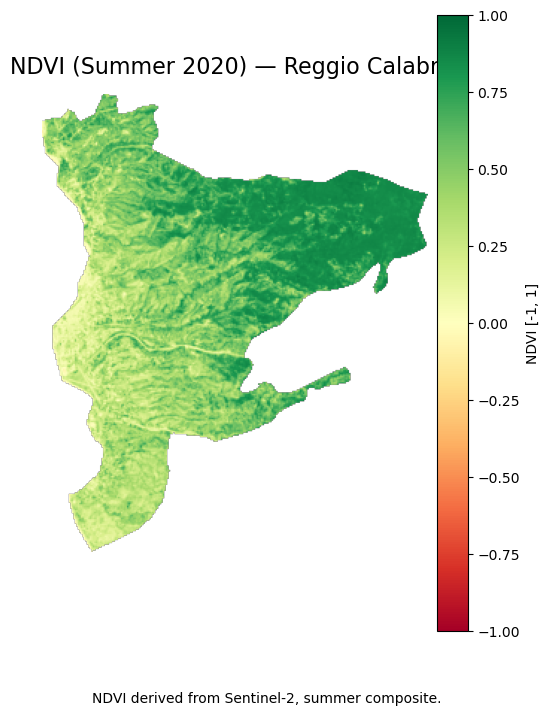

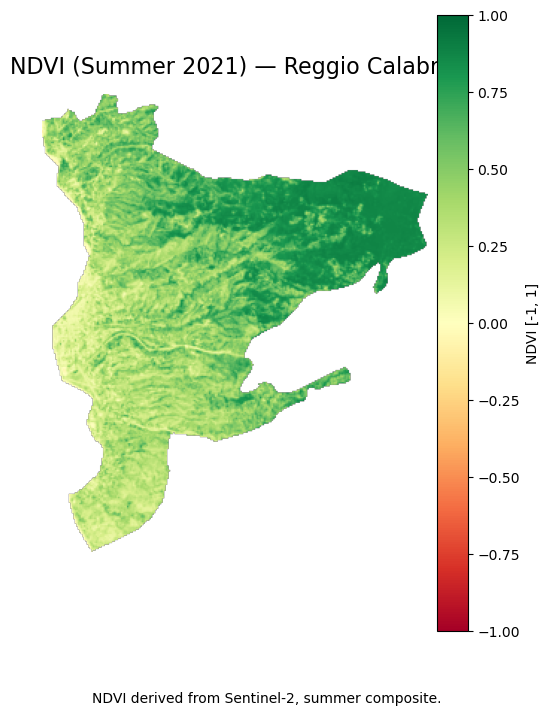

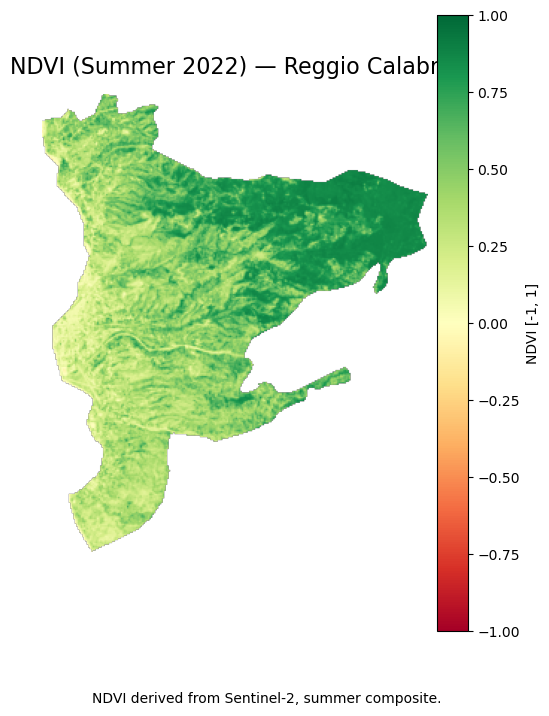

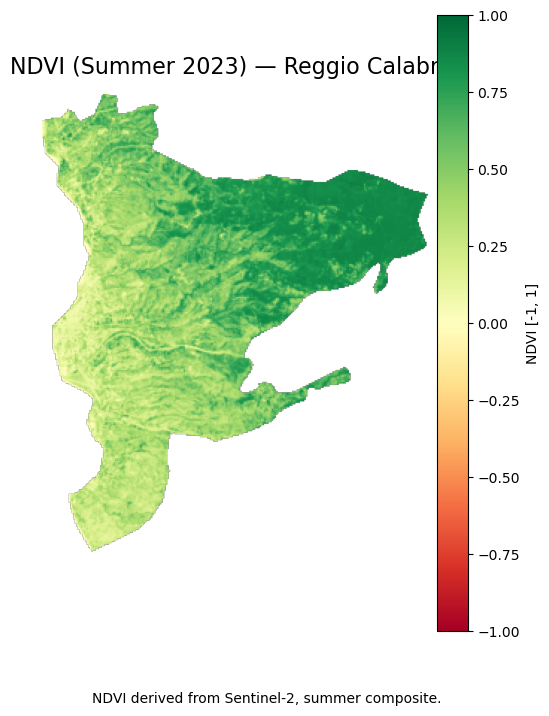

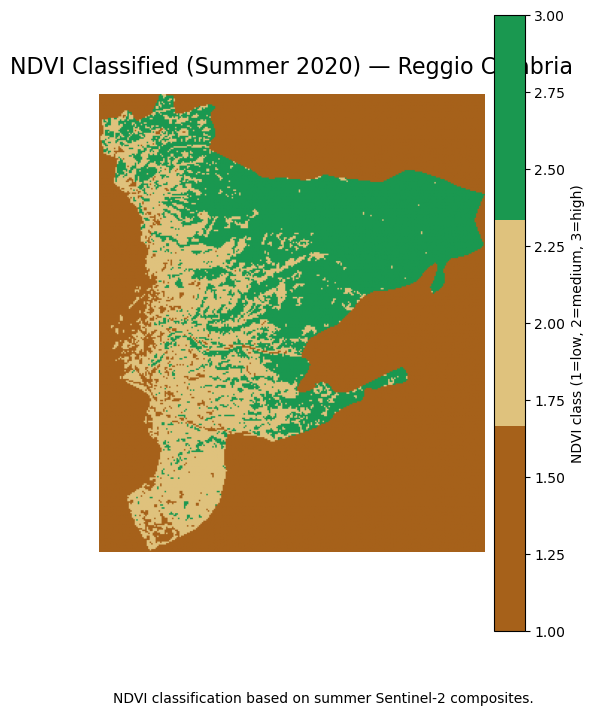

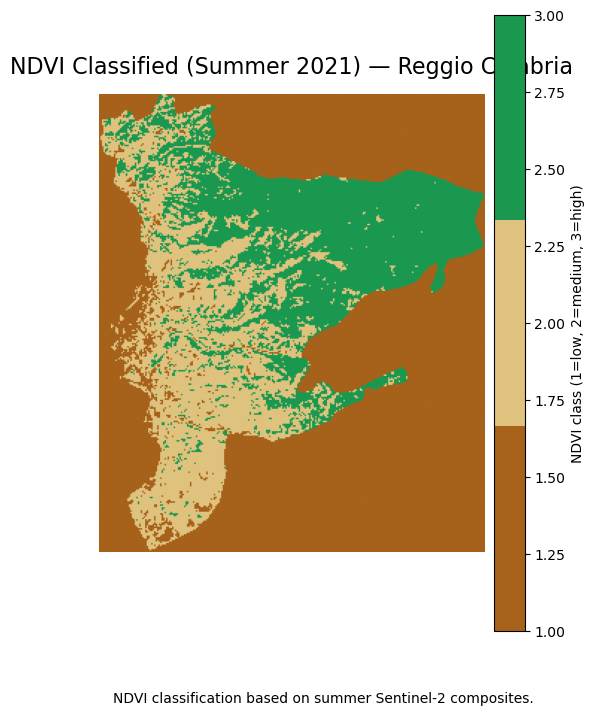

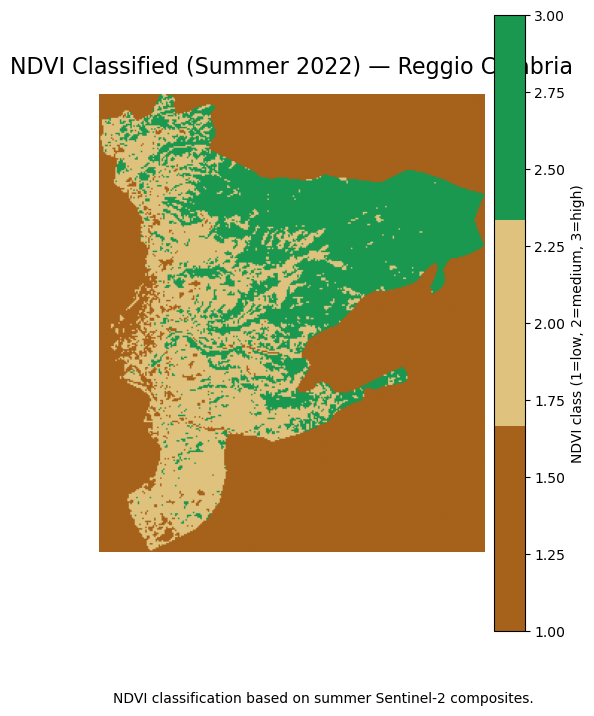

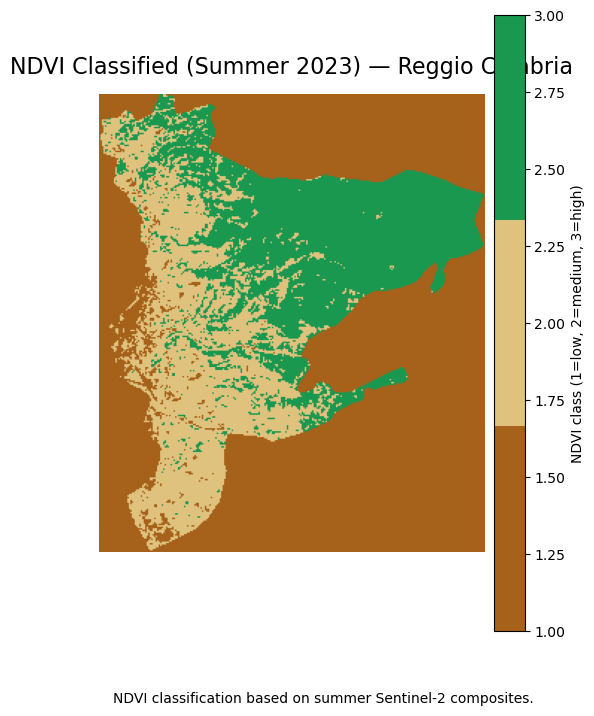

In [4]:
# ----------------------------
# 2. SENTINEL-2 NDVI PIPELINE
# ----------------------------

# 2.1 Load AOI in 4326 and 3035
aoi_geom_4326, aoi_geom_3035 = load_aoi_3035(SHP_PATH)

# 2.2 Sentinel-2 files & summer selection
files_s2 = find_s2_files(ROOT_S2)
print("Total Sentinel-2 NDVI files:", len(files_s2))

summer_by_year = build_summer_file_by_year(files_s2)
print("Summer mosaics by year (Sentinel-2):")
for y, f in summer_by_year.items():
    print(f"  {y}: {os.path.basename(f)}")

# 2.3 NDVI per summer per year, cropped to AOI
ndvi_by_year, ndvi_transform, ndvi_crs, ndvi_shape = load_ndvi_summer_by_year(
    summer_by_year,
    aoi_geom_3035
)

years_sorted = sorted(ndvi_by_year.keys())

# 2.4 Save NDVI GeoTIFF per year (float32, AOI only)
for year, ndvi in ndvi_by_year.items():
    sample_file = summer_by_year[year]
    with rasterio.open(sample_file) as src_ref:
        profile = src_ref.profile.copy()
        profile.update({
            "height": ndvi.shape[0],
            "width": ndvi.shape[1],
            "transform": ndvi_transform,
            "count": 1,
            "dtype": "float32",
            "nodata": np.nan
        })

    out_tif = os.path.join(OUT_DIR, f"ndvi_summer_{year}.tif")
    with rasterio.open(out_tif, "w", **profile) as dst:
        dst.write(ndvi.astype("float32"), 1)

    print(f"Saved NDVI TIFF: {out_tif}")

# 2.5 Example maps and layouts (optional, can comment out if not needed)
for year, ndvi in ndvi_by_year.items():
    plot_layout(
        ndvi,
        title=f"NDVI (Summer {year}) — Reggio Calabria",
        cbar_label="NDVI [-1, 1]",
        cmap="RdYlGn",
        vmin=-1,
        vmax=1,
        caption="NDVI derived from Sentinel-2, summer composite.",
        filename=f"ndvi_summer_{year}.png"
    )

# Classified NDVI (low–medium–high)
class_cmap = colors.ListedColormap(["#a6611a", "#dfc27d", "#1a9850"])
for year, ndvi in ndvi_by_year.items():
    ndvi_class = classify_ndvi(ndvi)
    plot_layout(
        ndvi_class,
        title=f"NDVI Classified (Summer {year}) — Reggio Calabria",
        cbar_label="NDVI class (1=low, 2=medium, 3=high)",
        cmap=class_cmap,
        vmin=1,
        vmax=3,
        caption="NDVI classification based on summer Sentinel-2 composites.",
        filename=f"ndvi_class_summer_{year}.png"
    )

In [5]:
# ----------------------------
# 3. ERA5 T2M – SUMMER MEANS
# ----------------------------

# 3.1 Open all ERA5 2m temperature daily max files
files_t2m = sorted(glob.glob(os.path.join(ERA5_FOLDER, "*_2m_temperature_daily_maximum.nc")))
print("Total ERA5 files (t2m):", len(files_t2m))

ds_all = xr.open_mfdataset(
    files_t2m,
    combine="by_coords",
    parallel=True,
    chunks={"latitude": 180, "longitude": 180, "valid_time": 50}
)

# 3.2 Restrict to summer (JJA)
ds_summer = ds_all.sel(valid_time=ds_all["valid_time"].dt.season == "JJA")

# 3.3 Summer mean per year (Kelvin → Celsius)
t2m_summer_mean = ds_summer["t2m"].groupby("valid_time.year").mean(dim="valid_time") - 273.15

Total ERA5 files (t2m): 11


C:\Users\Administrador\anaconda3\envs\andina\Lib\site-packages\dask\_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 50. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)
C:\Users\Administrador\anaconda3\envs\andina\Lib\site-packages\dask\_task_spec.py:758: UserWarning: The specified chunks separate the stored chunks along dimension "longitude" starting at index 180. This could degrade performance. Instead, consider rechunking after loading.
  return self.func(*new_argspec, **kwargs)


In [6]:
# ----------------------------
# 4. REPROJECT ERA5 TO NDVI GRID
# ----------------------------

# 4.1 Create yearly GeoTIFFs in ERA5 native grid (EPSG:4326)
era_tifs = {}

min_lon = float(ds_all.longitude.min())
max_lon = float(ds_all.longitude.max())
min_lat = float(ds_all.latitude.min())
max_lat = float(ds_all.latitude.max())

nlon = ds_all.dims["longitude"]
nlat = ds_all.dims["latitude"]

era_crs = "EPSG:4326"
transform_era = from_bounds(
    min_lon, min_lat, max_lon, max_lat,
    nlon, nlat
)

for y in t2m_summer_mean.year.values:
    arr = t2m_summer_mean.sel(year=y).values.astype("float32")

    out_tif = os.path.join(OUT_DIR, f"era5_t2m_summer_{int(y)}.tif")
    era_tifs[int(y)] = out_tif

    with rasterio.open(
        out_tif, "w",
        driver="GTiff",
        height=arr.shape[0],
        width=arr.shape[1],
        count=1,
        dtype="float32",
        crs=era_crs,
        transform=transform_era
    ) as dst:
        dst.write(arr, 1)

    print(f"Saved ERA5 TIFF: {out_tif}")

# 4.2 Reproject each ERA5 TIFF to NDVI (EPSG:3035, AOI grid)
era5_reproj = {}

for y, tif in era_tifs.items():
    with rasterio.open(tif) as src:
        era = src.read(1)
        era_transform = src.transform
        era_crs = src.crs

    era_out = np.empty(ndvi_shape, dtype=np.float32)

    reproject(
        source=era,
        destination=era_out,
        src_transform=era_transform,
        src_crs=era_crs,
        dst_transform=ndvi_transform,
        dst_crs=ndvi_crs,          # same CRS as NDVI (EPSG:3035)
        resampling=Resampling.bilinear
    )

    era5_reproj[y] = era_out

C:\Users\Administrador\AppData\Local\Temp\ipykernel_9472\2829536286.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlon = ds_all.dims["longitude"]
C:\Users\Administrador\AppData\Local\Temp\ipykernel_9472\2829536286.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  nlat = ds_all.dims["latitude"]


Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2015.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2016.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2017.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2018.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2019.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2020.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2021.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2022.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2023.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2024.tif
Saved ERA5 TIFF: C:\Users\Administrador\Downloads\ndvi_figures\era5_t2m_summer_2025.tif


In [7]:
# ----------------------------
# 5. AOI MASK & MEAN VALUES
# ----------------------------

# 5.1 Generate AOI mask on NDVI grid
mask_aoi = geometry_mask(
    geometries=[aoi_geom_3035],
    out_shape=ndvi_shape,
    transform=ndvi_transform,
    invert=True   # True = pixels inside AOI are True
)

# 5.2 Mean summer NDVI per year over AOI
ndvi_mean_aoi = {}
for y, ndvi in ndvi_by_year.items():
    ndvi_mean_aoi[y] = float(np.nanmean(ndvi[mask_aoi]))

# 5.3 Mean summer T2M per year over AOI
t2m_mean_aoi = {}
for y, arr in era5_reproj.items():
    t2m_mean_aoi[y] = float(np.nanmean(arr[mask_aoi]))

print("NDVI AOI mean by year:", ndvi_mean_aoi)
print("T2M  AOI mean by year:", t2m_mean_aoi)

NDVI AOI mean by year: {2020: 0.534081757068634, 2021: 0.5157379508018494, 2022: 0.5119829773902893, 2023: 0.5219392776489258}
T2M  AOI mean by year: {2015: 27.751737594604492, 2016: 26.71397590637207, 2017: 28.871978759765625, 2018: 26.883615493774414, 2019: 28.65130043029785, 2020: 27.248228073120117, 2021: 28.957597732543945, 2022: 28.99308204650879, 2023: 28.377824783325195, 2024: 29.777048110961914, 2025: 29.11610221862793}


Years used: [2020, 2021, 2022, 2023]
Correlation NDVI vs T2M (summer means, AOI): -0.9884510281587852


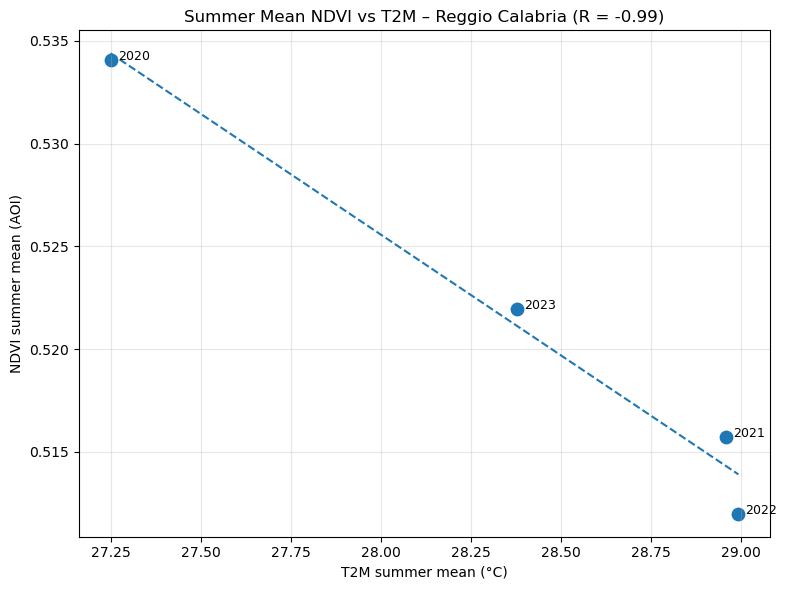

In [8]:
# ----------------------------
# 6. CORRELATION NDVI vs T2M
# ----------------------------

# Only years present in BOTH datasets
years_common = sorted(set(ndvi_mean_aoi.keys()) & set(t2m_mean_aoi.keys()))

ndvi_vals = np.array([ndvi_mean_aoi[y] for y in years_common], dtype="float32")
t2m_vals  = np.array([t2m_mean_aoi[y]  for y in years_common], dtype="float32")

# Pearson correlation (using numpy)
R = np.corrcoef(t2m_vals, ndvi_vals)[0, 1]
print("Years used:", years_common)
print("Correlation NDVI vs T2M (summer means, AOI):", R)

# Scatter plot with regression line
plt.figure(figsize=(8, 6))
plt.scatter(t2m_vals, ndvi_vals, s=80)

# Regression line
m, b = np.polyfit(t2m_vals, ndvi_vals, 1)
x_line = np.linspace(t2m_vals.min(), t2m_vals.max(), 100)
plt.plot(x_line, m * x_line + b, linestyle="--")

# Annotate each point with the year
for x, yv, yr in zip(t2m_vals, ndvi_vals, years_common):
    plt.text(x + 0.02, yv, str(yr), fontsize=9)

plt.title(f"Summer Mean NDVI vs T2M – Reggio Calabria (R = {R:.2f})")
plt.xlabel("T2M summer mean (°C)")
plt.ylabel("NDVI summer mean (AOI)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "ndvi_t2m_correlation.png"), dpi=300, bbox_inches="tight")
plt.show()

In [11]:
!pip install seaborn


In [12]:
# ============================================================
# ADVANCED VISUALIZATION SUITE FOR NDVI vs TEMPERATURE ANALYSIS
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap

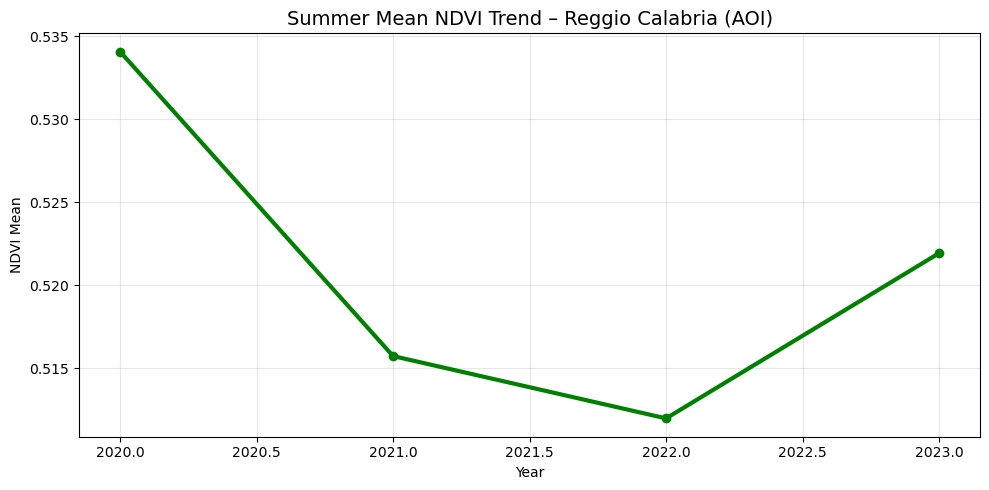

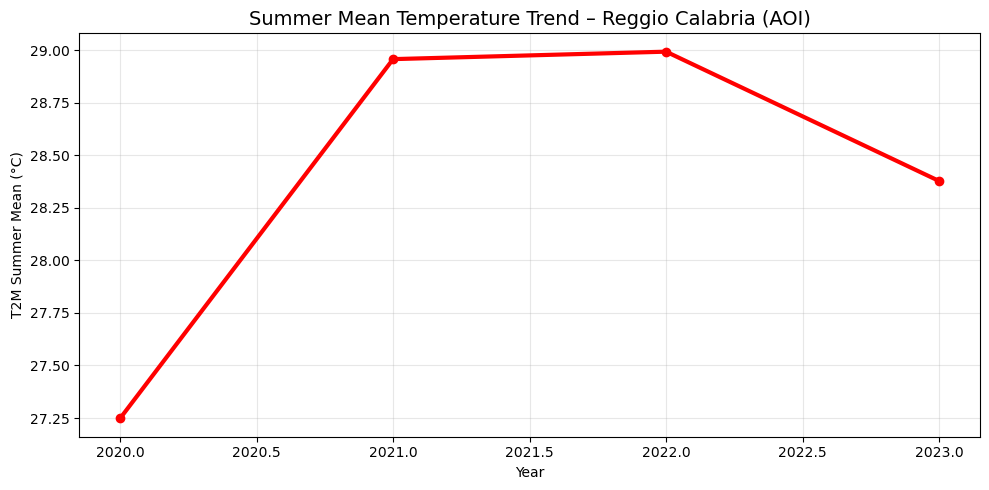

In [13]:
# ------------------------------------------------------------
# 1. TIME SERIES PLOTS
# ------------------------------------------------------------

# --- A. NDVI summer mean trend ---
years_common = sorted(ndvi_mean_aoi.keys())
ndvi_vals = [ndvi_mean_aoi[y] for y in years_common]

plt.figure(figsize=(10,5))
plt.plot(years_common, ndvi_vals, marker="o", linewidth=3, color="green")
plt.title("Summer Mean NDVI Trend – Reggio Calabria (AOI)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("NDVI Mean")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/trend_ndvi_mean.png", dpi=300)
plt.show()


# --- B. Temperature summer mean trend ---
t2m_vals = [t2m_mean_aoi[y] for y in years_common]

plt.figure(figsize=(10,5))
plt.plot(years_common, t2m_vals, marker="o", linewidth=3, color="red")
plt.title("Summer Mean Temperature Trend – Reggio Calabria (AOI)", fontsize=14)
plt.xlabel("Year")
plt.ylabel("T2M Summer Mean (°C)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/trend_t2m_mean.png", dpi=300)
plt.show()

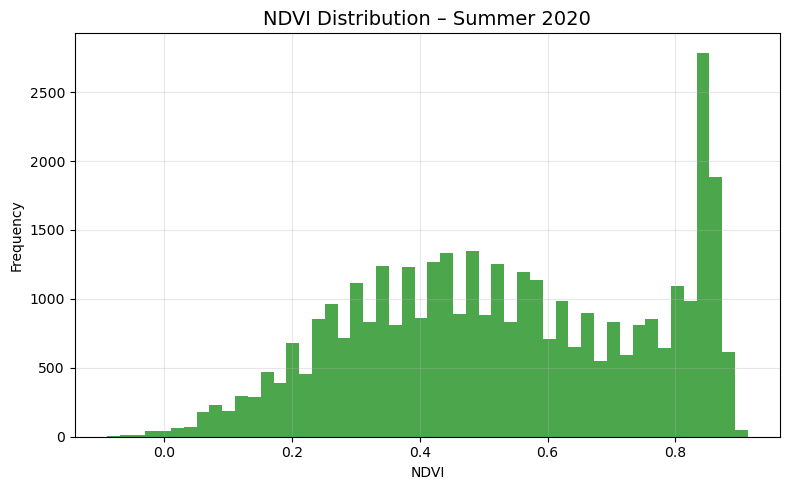

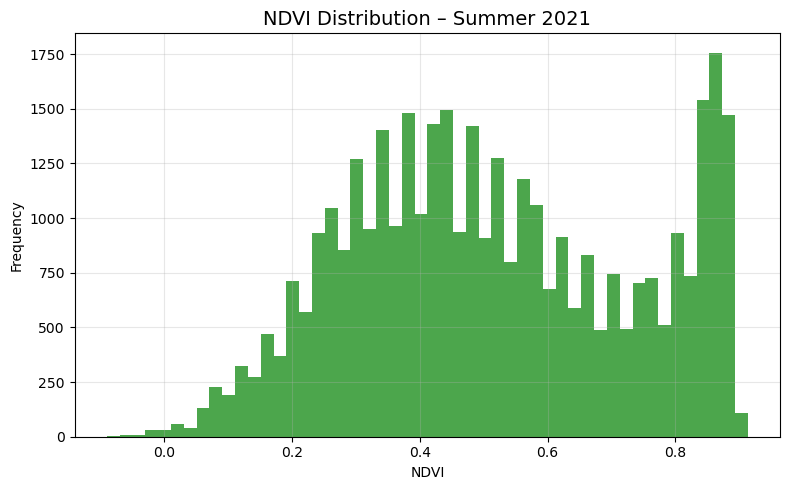

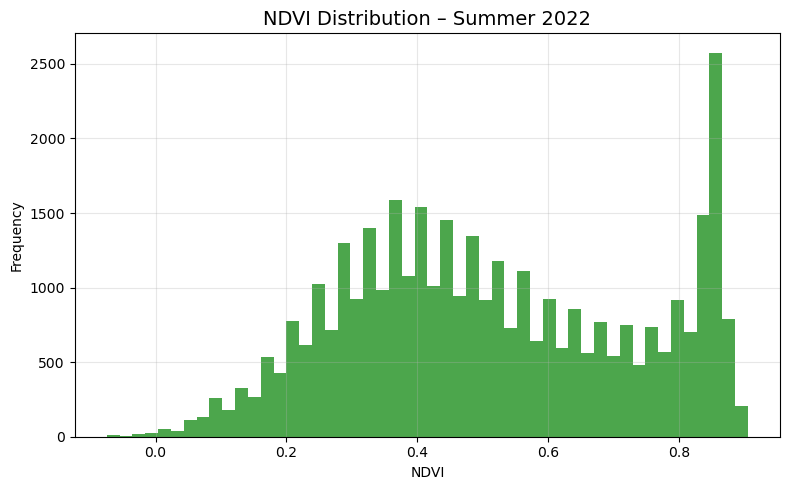

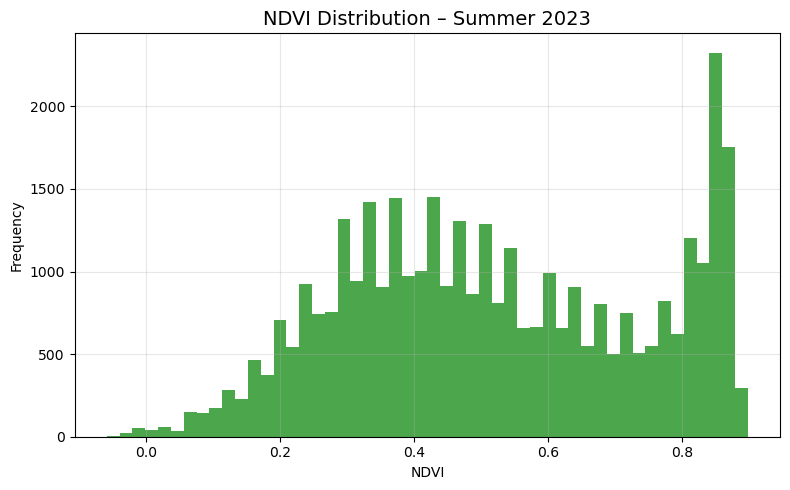

In [14]:
# ------------------------------------------------------------
# 2. NDVI DISTRIBUTION (PER YEAR)
# ------------------------------------------------------------

# For each year → histogram of pixel values
for year in years_sorted:
    ndvi = ndvi_by_year[year][mask_aoi].flatten()
    ndvi = ndvi[~np.isnan(ndvi)]

    plt.figure(figsize=(8,5))
    plt.hist(ndvi, bins=50, color="green", alpha=0.7)
    plt.title(f"NDVI Distribution – Summer {year}", fontsize=14)
    plt.xlabel("NDVI")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/hist_ndvi_{year}.png", dpi=300)
    plt.show()

C:\Users\Administrador\AppData\Local\Temp\ipykernel_9472\2457554449.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=box_years, patch_artist=True,


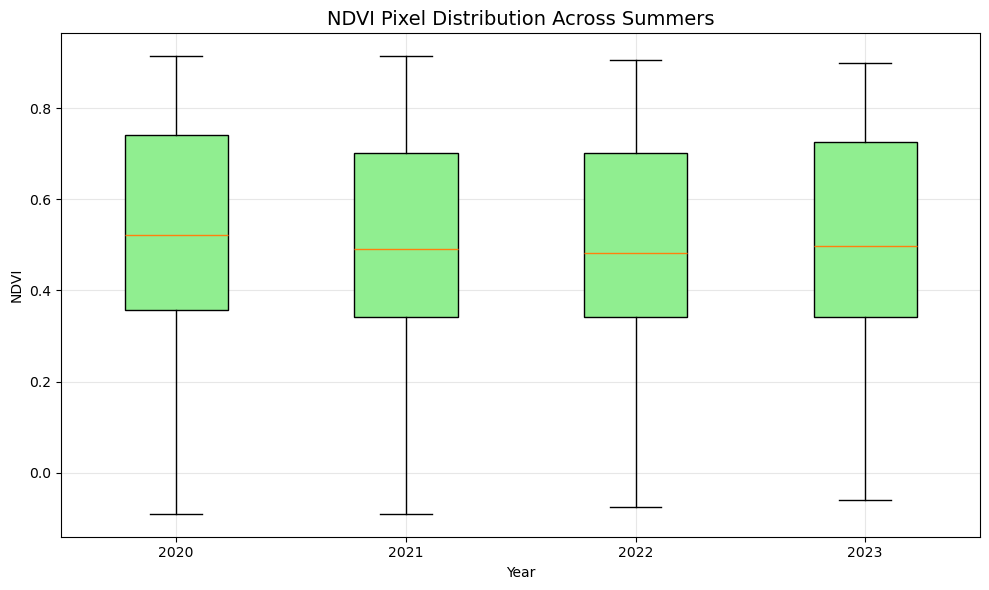

In [15]:
# ------------------------------------------------------------
# 3. BOX PLOT: NDVI pixel distribution over all years
# ------------------------------------------------------------

box_data = []
box_years = []

for year in years_sorted:
    arr = ndvi_by_year[year][mask_aoi].flatten()
    box_data.append(arr[~np.isnan(arr)])
    box_years.append(year)

plt.figure(figsize=(10,6))
plt.boxplot(box_data, labels=box_years, patch_artist=True,
            boxprops=dict(facecolor='lightgreen'))
plt.title("NDVI Pixel Distribution Across Summers", fontsize=14)
plt.xlabel("Year")
plt.ylabel("NDVI")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/boxplot_ndvi.png", dpi=300)
plt.show()

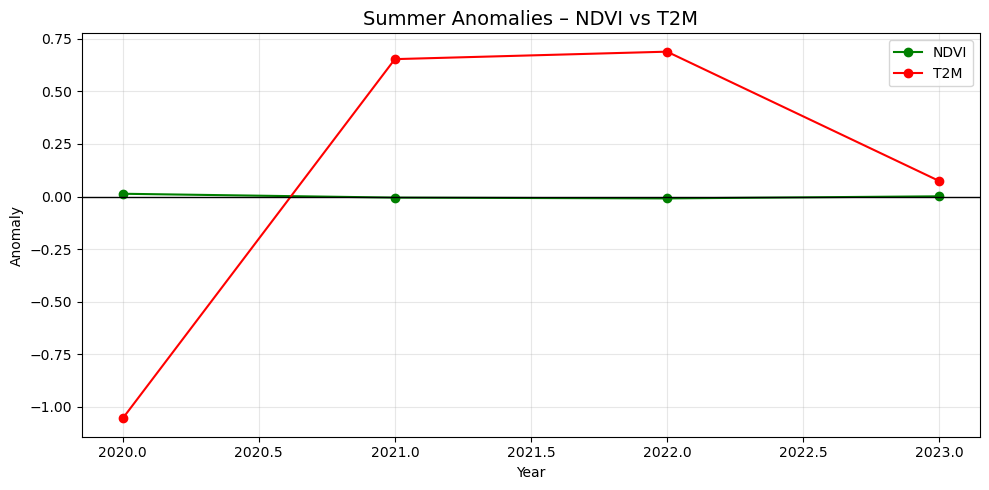

In [16]:
# ------------------------------------------------------------
# 4. NDVI ANOMALIES & T2M ANOMALIES
# ------------------------------------------------------------

ndvi_anom = {y: ndvi_mean_aoi[y] - np.mean(list(ndvi_mean_aoi.values())) for y in years_common}
t2m_anom  = {y: t2m_mean_aoi[y]  - np.mean(list(t2m_mean_aoi.values())) for y in years_common}

plt.figure(figsize=(10,5))
plt.plot(years_common, ndvi_anom.values(), marker="o", label="NDVI", color="green")
plt.plot(years_common, t2m_anom.values(), marker="o", label="T2M", color="red")
plt.axhline(0, color="black", linewidth=1)

plt.title("Summer Anomalies – NDVI vs T2M", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Anomaly")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/anomalies_ndvi_t2m.png", dpi=300)
plt.show()

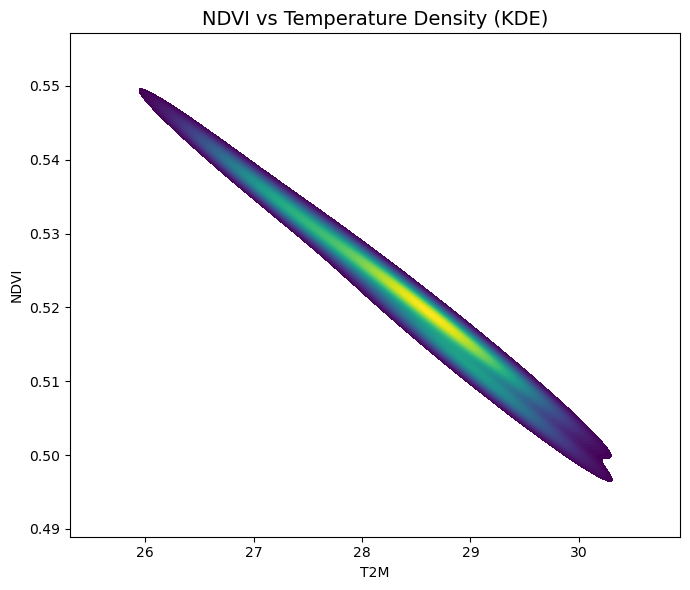

In [17]:
# ------------------------------------------------------------
# 5. 2D HEATMAP (NDVI vs T2M)
# ------------------------------------------------------------

df_corr = pd.DataFrame({
    "year": years_common,
    "ndvi": [ndvi_mean_aoi[y] for y in years_common],
    "t2m":  [t2m_mean_aoi[y] for y in years_common]
})

plt.figure(figsize=(7,6))
sns.kdeplot(
    x=df_corr["t2m"],
    y=df_corr["ndvi"],
    fill=True,
    cmap="viridis",
    thresh=0.05,
    levels=100
)
plt.title("NDVI vs Temperature Density (KDE)", fontsize=14)
plt.xlabel("T2M")
plt.ylabel("NDVI")
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/kde_ndvi_t2m.png", dpi=300)
plt.show()

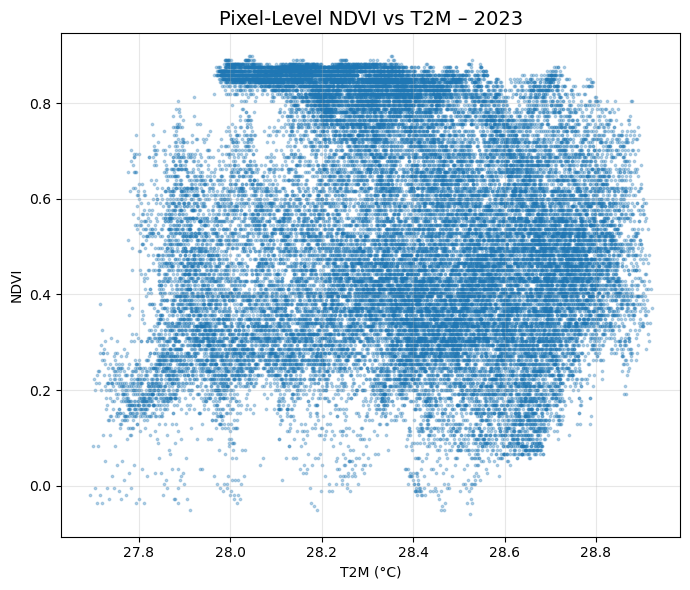

In [18]:
# ------------------------------------------------------------
# 6. PIXEL-LEVEL NDVI vs T2M (if wanting deep spatial correlation)
# ------------------------------------------------------------

# Build pixel-level dataframe for the latest year (example)
latest = years_sorted[-1]

ndvi_pix = ndvi_by_year[latest].flatten()
t2m_pix  = era5_reproj[latest].flatten()

mask = (~np.isnan(ndvi_pix)) & (~np.isnan(t2m_pix))
ndvi_pix = ndvi_pix[mask]
t2m_pix = t2m_pix[mask]

plt.figure(figsize=(7,6))
plt.scatter(t2m_pix, ndvi_pix, s=3, alpha=0.3)
plt.title(f"Pixel-Level NDVI vs T2M – {latest}", fontsize=14)
plt.xlabel("T2M (°C)")
plt.ylabel("NDVI")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/pixel_scatter_{latest}.png", dpi=300)
plt.show()

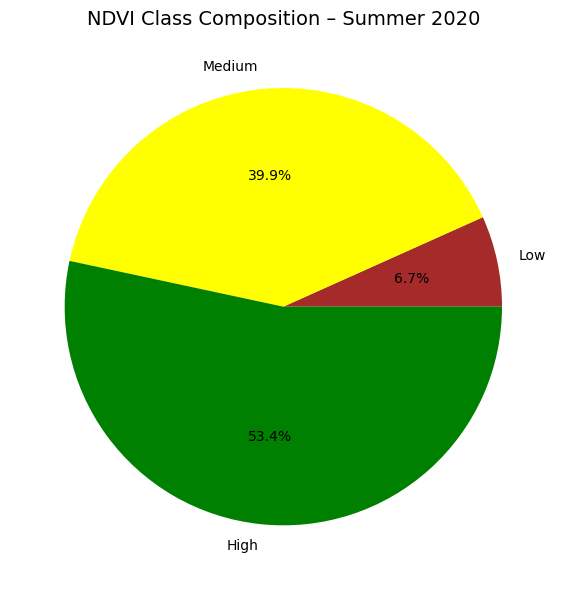

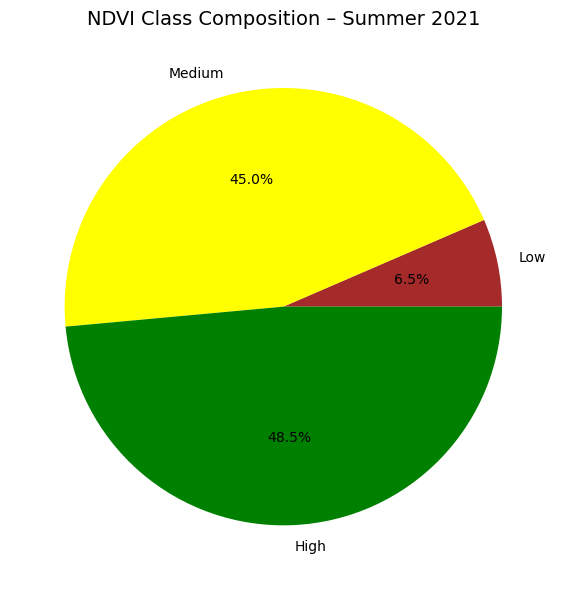

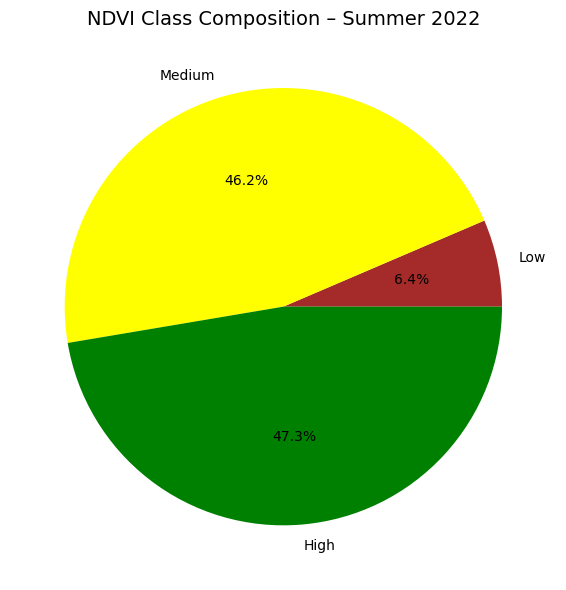

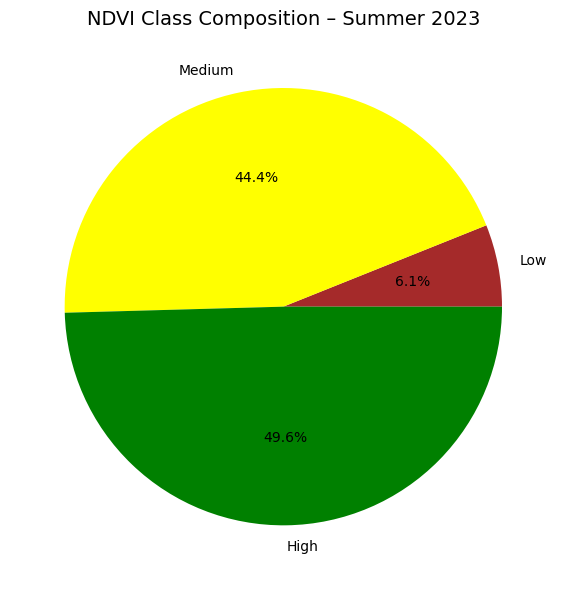

In [19]:
# ------------------------------------------------------------
# 7. NDVI CLASSIFICATION PIE CHARTS
# ------------------------------------------------------------

def classify_ndvi(arr):
    arr = arr.copy()
    classes = np.zeros_like(arr, dtype=np.uint8)
    classes[(arr >= -1) & (arr < 0.2)] = 1
    classes[(arr >= 0.2) & (arr < 0.5)] = 2
    classes[(arr >= 0.5)] = 3
    return classes

for year in years_sorted:
    ndvi = ndvi_by_year[year]
    ndvi_class = classify_ndvi(ndvi[mask_aoi])

    labels = ["Low", "Medium", "High"]
    counts = [
        np.sum(ndvi_class == 1),
        np.sum(ndvi_class == 2),
        np.sum(ndvi_class == 3)
    ]

    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%',
            colors=["brown", "yellow", "green"])
    plt.title(f"NDVI Class Composition – Summer {year}", fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/pie_ndvi_classes_{year}.png", dpi=300)
    plt.show()

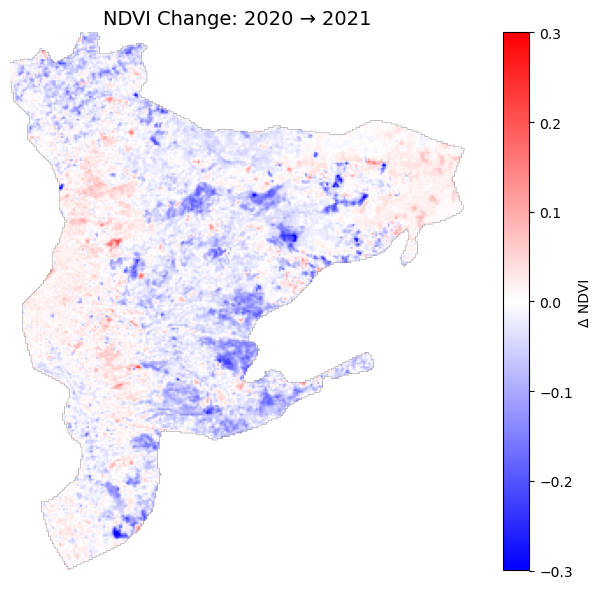

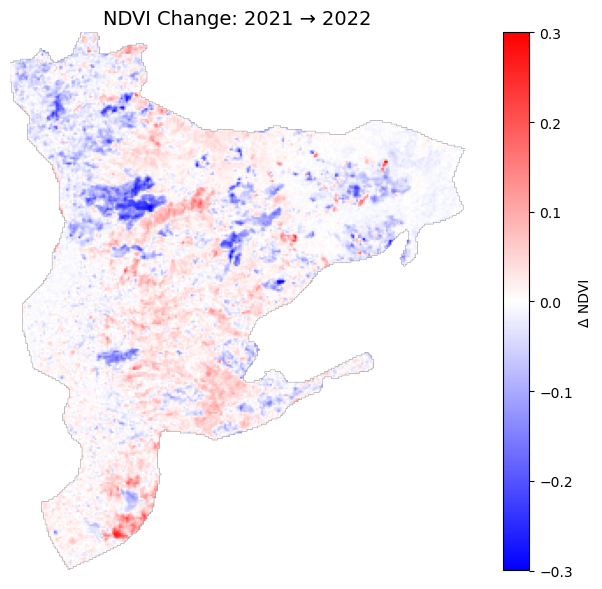

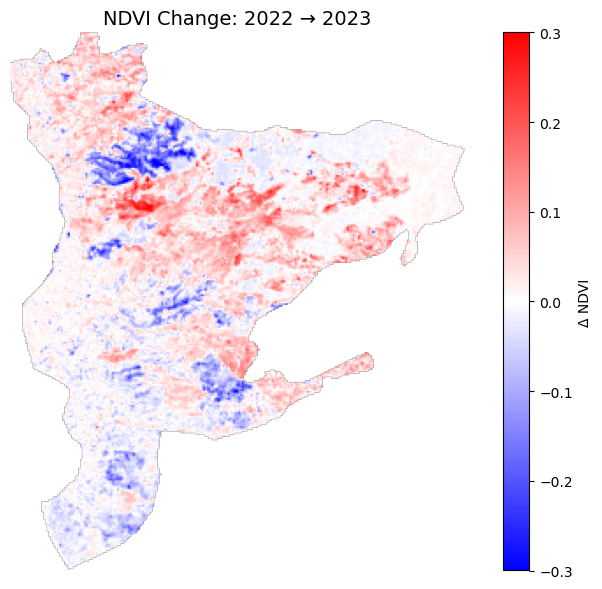

In [20]:
# ------------------------------------------------------------
# 8. Δ NDVI YEAR-TO-YEAR SPATIAL CHANGE
# ------------------------------------------------------------

for i in range(1, len(years_sorted)):
    y1 = years_sorted[i-1]
    y2 = years_sorted[i]

    diff = ndvi_by_year[y2] - ndvi_by_year[y1]

    plt.figure(figsize=(8,6))
    plt.imshow(diff, cmap="bwr", vmin=-0.3, vmax=0.3)
    plt.colorbar(label="Δ NDVI")
    plt.title(f"NDVI Change: {y1} → {y2}", fontsize=14)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{OUT_DIR}/ndvi_diff_{y1}_{y2}.png", dpi=300)
    plt.show()

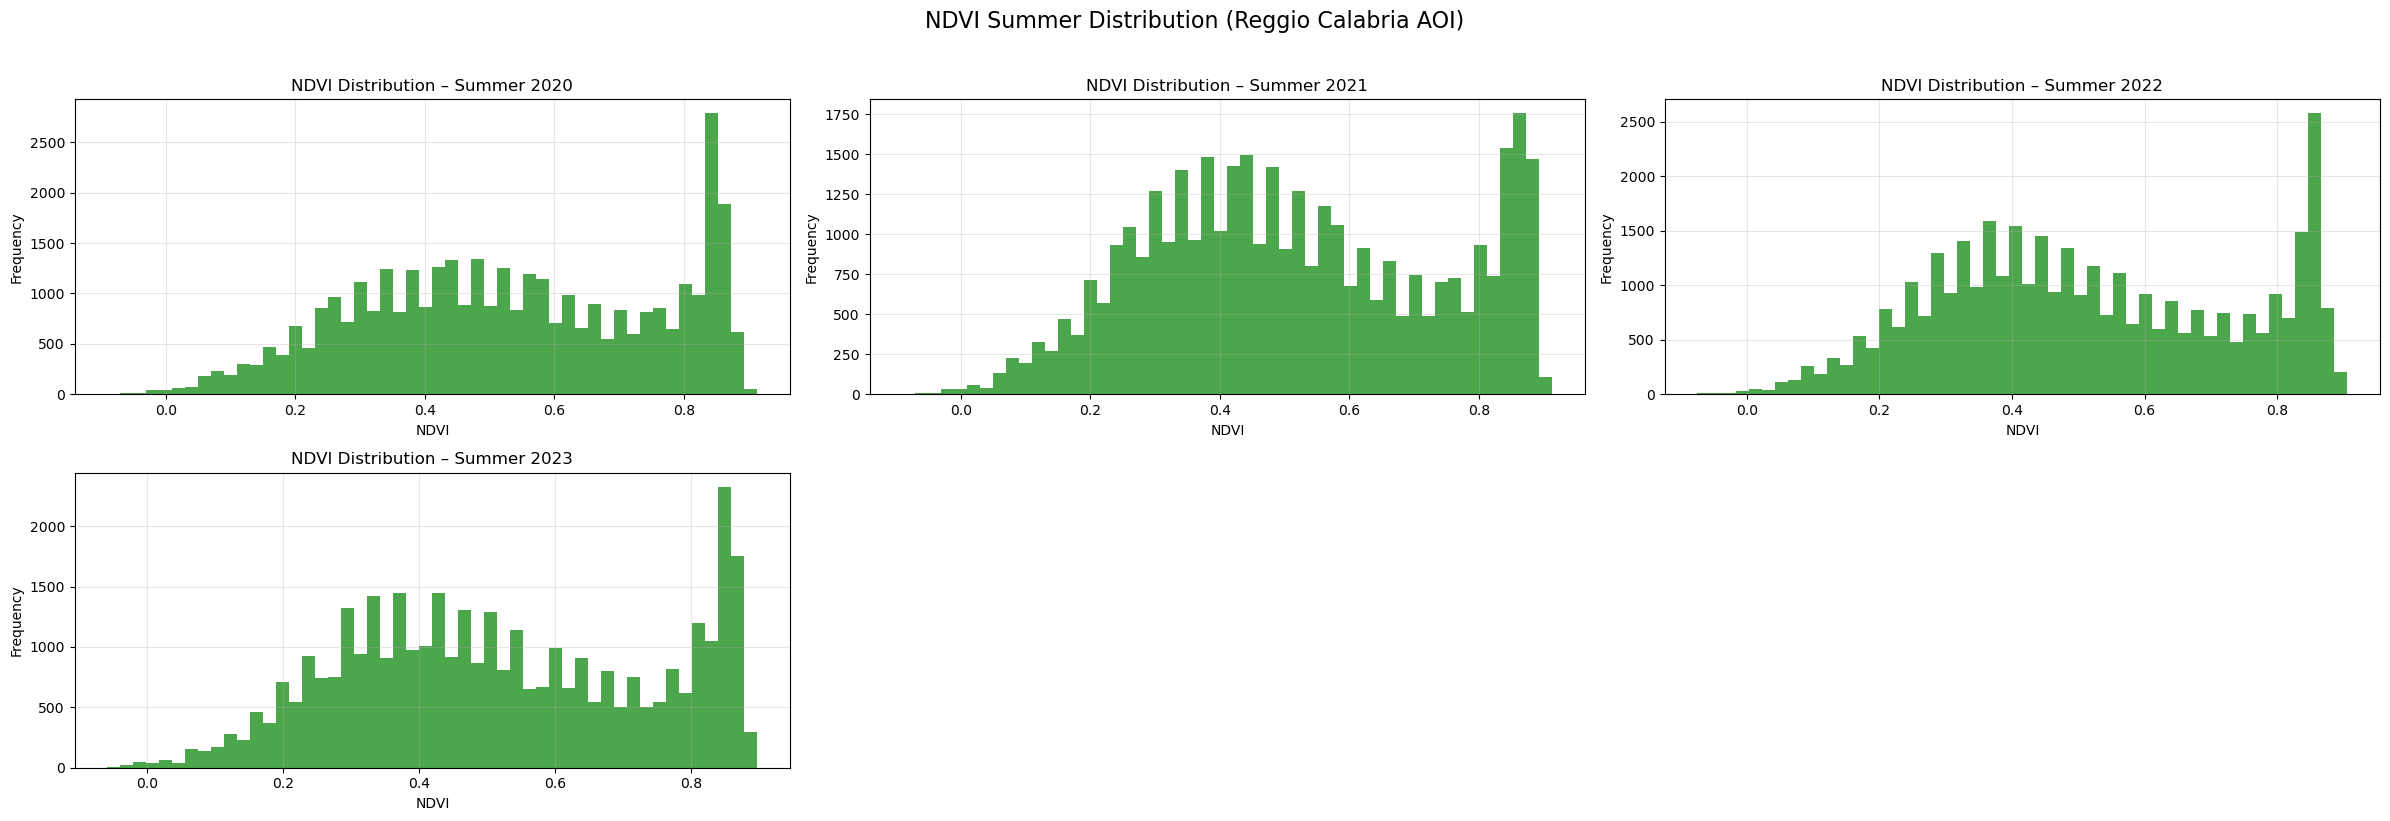

In [26]:
# ------------------------------------------------------------
# 9. 1-ROW LAYOUT OF ALL NDVI IMAGES (SUMMARY)
# ------------------------------------------------------------

n = len(years_sorted)
fig, axes = plt.subplots(1, n, figsize=(5*n, 5))

for i, year in enumerate(years_sorted):
    ax = axes[i]
    im = ax.imshow(ndvi_by_year[year], cmap="RdYlGn", vmin=-1, vmax=1)
    ax.set_title(f"{year}")
    ax.axis("off")

fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.03])
cbar = fig.colorbar(im, cax=cbar_ax, orientation="horizontal")
cbar.set_label("NDVI [-1,1]")

plt.savefig(f"{OUT_DIR}/layout_ndvi_all_years.png", dpi=300, bbox_inches='tight')
plt.show()

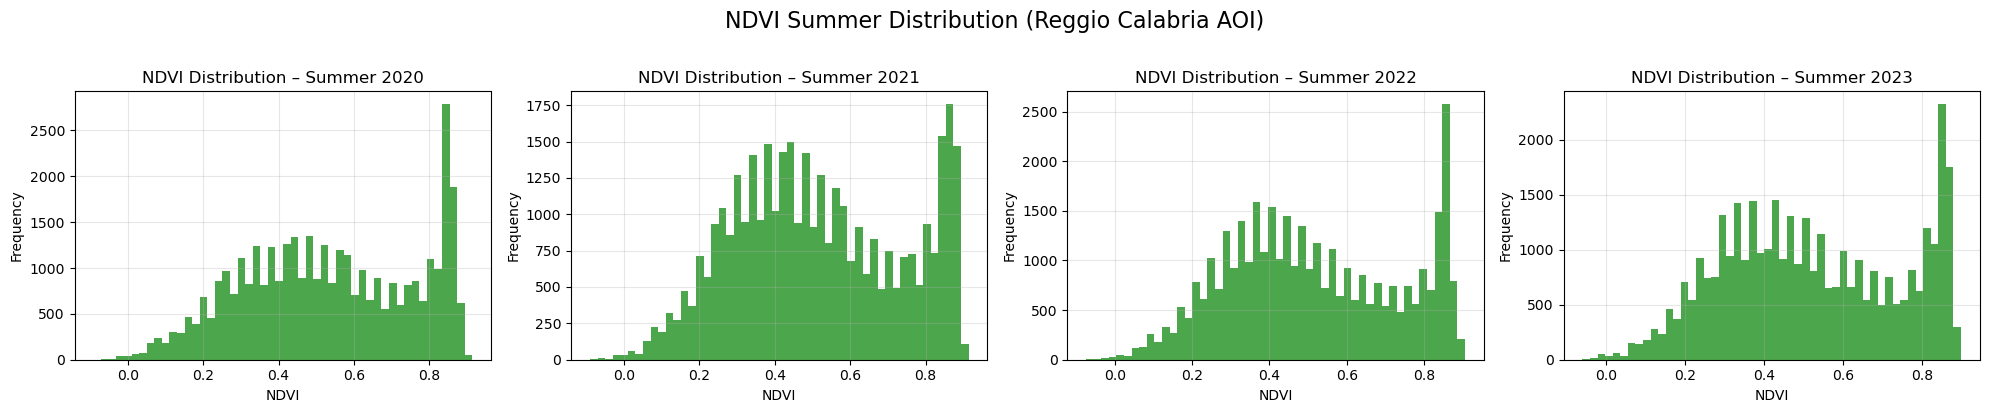

In [27]:
# ============================================================
# LAYOUT PLOT: NDVI SUMMER DISTRIBUTION (HISTOGRAMS FOR ALL YEARS)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np
import math

# Prepare data: per-year flattened NDVI inside AOI
hist_data = {}
for year in years_sorted:
    arr = ndvi_by_year[year][mask_aoi].flatten()
    arr = arr[~np.isnan(arr)]
    hist_data[year] = arr

# How many years?
n_years = len(years_sorted)

# Grid size: auto-arranged square layout
cols = 4
rows = math.ceil(n_years / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4), squeeze=False)

# Flatten axes array for easy indexing
axes_flat = axes.flatten()

# Plot each year's histogram
for idx, year in enumerate(years_sorted):
    ax = axes_flat[idx]
    
    data = hist_data[year]
    
    ax.hist(data, bins=50, color="green", alpha=0.7)
    ax.set_title(f"NDVI Distribution – Summer {year}", fontsize=12)
    ax.set_xlabel("NDVI")
    ax.set_ylabel("Frequency")
    ax.grid(alpha=0.3)

# Hide empty subplots (if any)
for j in range(idx+1, rows*cols):
    axes_flat[j].axis("off")

plt.suptitle("NDVI Summer Distribution (Reggio Calabria AOI)", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/layout_ndvi_summer_histograms.png", dpi=300, bbox_inches="tight")
plt.show()


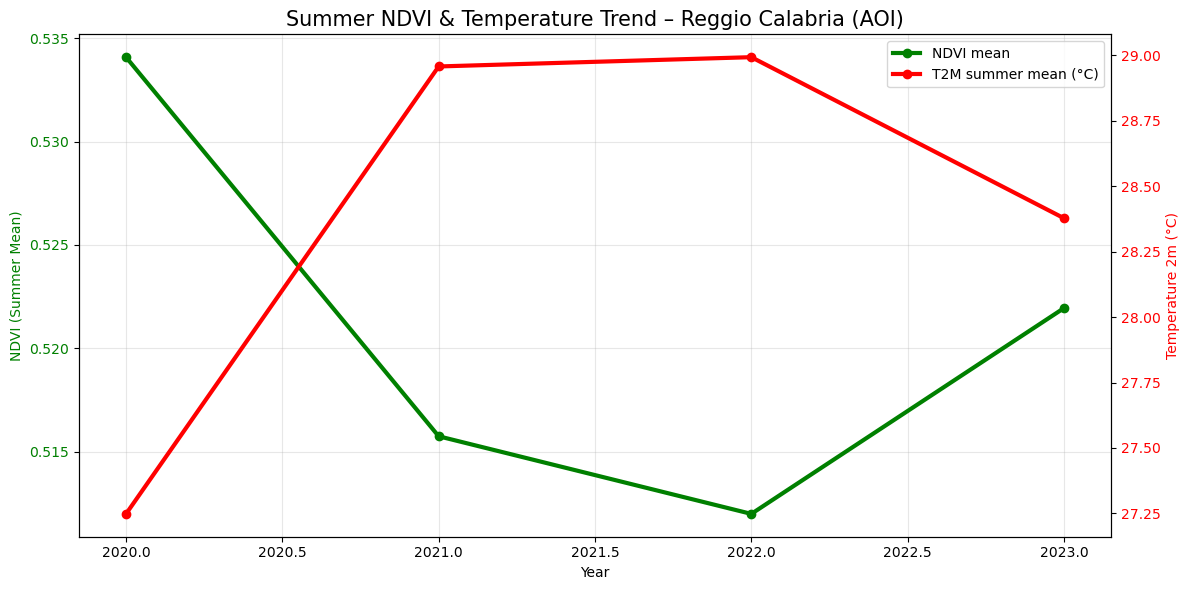

In [23]:
# ============================================================
# SINGLE FIGURE: NDVI + T2M Summer Trend (Dual Axis)
# ============================================================

import matplotlib.pyplot as plt
import numpy as np

years = years_common
ndvi_vals = [ndvi_mean_aoi[y] for y in years]
t2m_vals  = [t2m_mean_aoi[y] for y in years]

plt.figure(figsize=(12,6))

# --- NDVI (Left Axis) ---
ax1 = plt.gca()
lns1 = ax1.plot(
    years, ndvi_vals,
    marker="o", linewidth=3, color="green", label="NDVI mean"
)
ax1.set_ylabel("NDVI (Summer Mean)", color="green")
ax1.tick_params(axis="y", labelcolor="green")

# --- Temperature (Right Axis) ---
ax2 = ax1.twinx()
lns2 = ax2.plot(
    years, t2m_vals,
    marker="o", linewidth=3, color="red", label="T2M summer mean (°C)"
)
ax2.set_ylabel("Temperature 2m (°C)", color="red")
ax2.tick_params(axis="y", labelcolor="red")

# --- Title & Styling ---
plt.title("Summer NDVI & Temperature Trend – Reggio Calabria (AOI)", fontsize=15)
ax1.set_xlabel("Year")
ax1.grid(alpha=0.3)

# --- Combine the legends ---
lns = lns1 + lns2
labels = [l.get_label() for l in lns]
plt.legend(lns, labels, loc="upper right")

plt.tight_layout()
plt.savefig(f"{OUT_DIR}/ndvi_t2m_trend_combined.png", dpi=300)
plt.show()
